# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [57]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [80]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
stopwords_set = stopwords.words('english')

def stem_corpus(tokenized_data):
    return [[stemmer.stem(token) for token in text] for text in tokenized_data]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Роман\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
%%time

train_tokenized = stem_corpus(train_tokenized)
test_tokenized = stem_corpus(test_tokenized)

train_tokenized = [[token for token in text if token not in stopwords_set] for text in train_tokenized]
test_tokenized = [[token for token in text if token not in stopwords_set] for text in test_tokenized]

CPU times: total: 27 s
Wall time: 27 s


In [83]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 15672
[('write', 0), ('post', 1), ('articl', 2), ('univ', 3), ('host', 4), ('nntp', 5), ('would', 6), ('like', 7), ('know', 8), ('think', 9)]


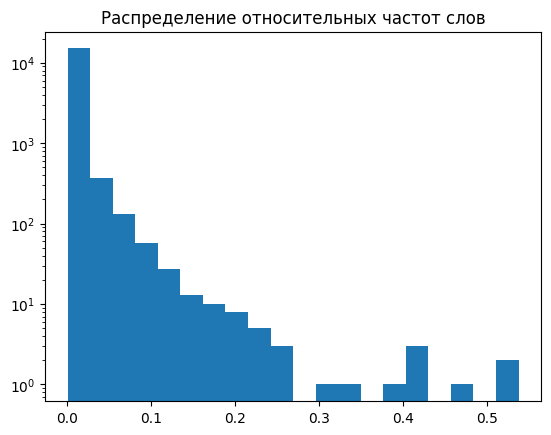

In [84]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [85]:
VECTORIZATION_MODE = 'tf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 15672)
Размерность матрицы признаков тестовой выборки (7532, 15672)

Количество ненулевых элементов в обучающей выборке 941778
Процент заполненности матрицы признаков 0.53%

Количество ненулевых элементов в тестовой выборке 604061
Процент заполненности матрицы признаков 0.51%


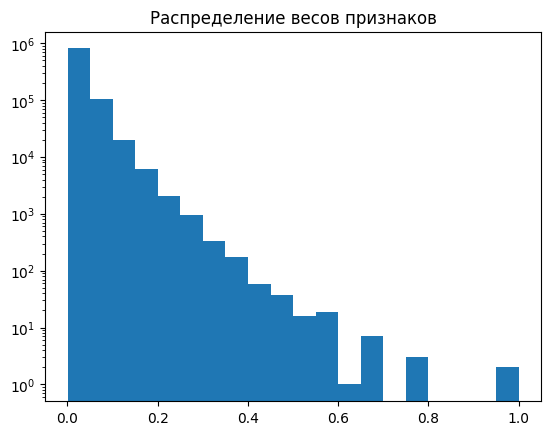

In [86]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [87]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


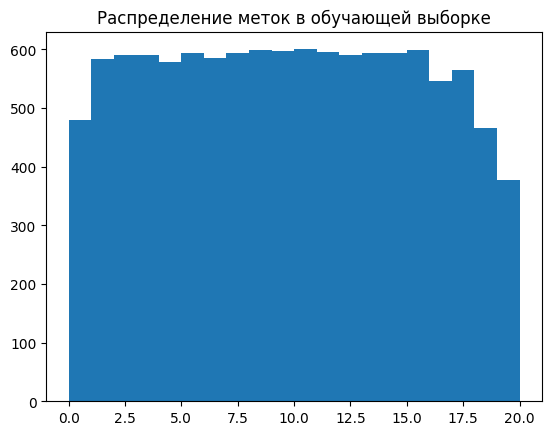

In [88]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

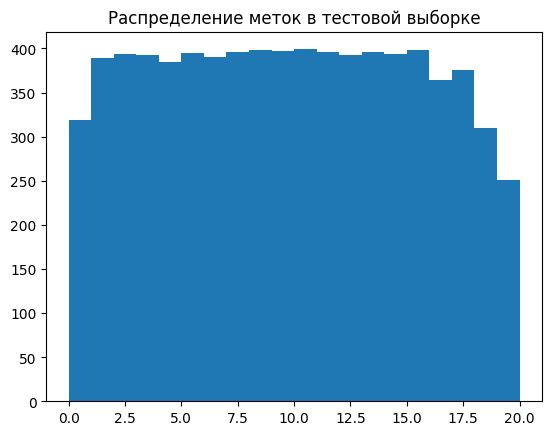

In [89]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [90]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [91]:
# model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)
model = nn.Sequential(
    nn.Linear(UNIQUE_WORDS_N, 256),
    nn.ReLU(),
    nn.Linear(256, UNIQUE_LABELS_N)
)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=0.0001,
                                            epoch_n=200,
                                            device='cuda',
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 2.37 сек
Среднее значение функции потерь на обучении 2.9776998778521
Среднее значение функции потерь на валидации 2.9569433149644886
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 2.34 сек
Среднее значение функции потерь на обучении 2.878460001137297
Среднее значение функции потерь на валидации 2.839824103702933
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 2.35 сек
Среднее значение функции потерь на обучении 2.674840205133298
Среднее значение функции потерь на валидации 2.6512712694830816
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 2.36 сек
Среднее значение функции потерь на обучении 2.4015206819200245
Среднее значение функции потерь на валидации 2.4277927067320224
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 2.37 сек
Среднее значение функции потерь на обучении 2.103313376337795
Среднее значение функции потерь на валидации 2.199764918472807
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.35 сек
Среднее значение функции потерь на 

Эпоха: 354 итераций, 2.41 сек
Среднее значение функции потерь на обучении 0.045732713096622524
Среднее значение функции потерь на валидации 0.5655938763234575
Новая лучшая модель!

Эпоха 45
Эпоха: 354 итераций, 2.41 сек
Среднее значение функции потерь на обучении 0.04214605239698779
Среднее значение функции потерь на валидации 0.5624707618381007
Новая лучшая модель!

Эпоха 46
Эпоха: 354 итераций, 2.10 сек
Среднее значение функции потерь на обучении 0.03891754563303275
Среднее значение функции потерь на валидации 0.5601513788609181
Новая лучшая модель!

Эпоха 47
Эпоха: 354 итераций, 2.27 сек
Среднее значение функции потерь на обучении 0.03588276680843052
Среднее значение функции потерь на валидации 0.5589479581152988
Новая лучшая модель!

Эпоха 48
Эпоха: 354 итераций, 2.32 сек
Среднее значение функции потерь на обучении 0.03308413523949136
Среднее значение функции потерь на валидации 0.5557692873023324
Новая лучшая модель!

Эпоха 49
Эпоха: 354 итераций, 2.37 сек
Среднее значение функции

## Оценка качества

In [92]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████████████████████████████████████████████████████████████████████| 354/353.5625 [00:01<00:00, 232.60it/s]


Среднее значение функции потерь на обучении 0.013538988307118416
Доля верных ответов 0.9991161392964468



236it [00:01, 223.65it/s]                                                                                              

Среднее значение функции потерь на валидации 0.5483399033546448
Доля верных ответов 0.8421402018056293


# Альтернативная реализация на scikit-learn

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [19]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']).type(torch.LongTensor))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']).type(torch.LongTensor))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918555657
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.65390225823174
Доля верных ответов 0.8190387679235263
